<a href="https://colab.research.google.com/github/a-maksimov/data_analysis/blob/main/kinopoisk_reviews_word2vec_sentiment_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Defining the questions

Q.1 How accurate can we predict a positive or a negative sentiment of a movie review?

We will be using a dataset of positive and negative movie reviews from Kinopoisk to train a word2vec model.

They we will convert each review into a document-level vector and use them as features for Catboost 

https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews

In [5]:
!unzip -oq '/content/drive/MyDrive/Datasets/Kinopoisk/kinopoisk_reviews.zip'

In [6]:
#@title Imports
import os
import pandas as pd
import re
import string
import spacy
from time import time
from datetime import datetime
from collections import defaultdict
from gensim.models import Word2Vec
import multiprocessing
from random import randint

In [7]:
#@title Download spaCy language packs

!python -m spacy download ru_core_news_sm --quiet
!python -m spacy download en_core_web_sm --quiet

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-11 14:14:16.870651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-11 14:14:16.870761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-11 14:14:16.870814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

We label positive reviews as "1" and negative reviews as "0".

In [8]:
review_dicts = []
filepath = '/content/dataset/neg/'
for filename in os.listdir(filepath):
  review_dict = {}
  review_dict['review_id'] = filename.split('.')[0]
  with open(filepath + filename, 'r', encoding='utf-8') as file:
    review_dict['review_content'] = file.read()
  review_dict['label'] = 0
  review_dicts.append(review_dict)

In [9]:
filepath = '/content/dataset/pos/'
for filename in os.listdir(filepath):
  review_dict = {}
  review_dict['review_id'] = filename.split('.')[0]
  with open(filepath + filename, 'r', encoding='utf-8') as file:
    review_dict['review_content'] = file.read()
  review_dict['label'] = 1
  review_dicts.append(review_dict)

In [10]:
df = pd.DataFrame.from_dict(review_dicts)

In [11]:
df

,review_id,review_content,label
0,418794-74,Он был один из самых славных и любимых европей...,0
1,721154-67,Стратовулкан Фудзи на протяжении веков являлся...,0
2,42367-5,"Искусство, по-моему, – отражение борьбы и трев...",0
3,467166-31,'Бывшему бойцу британских силовых структур при...,0
4,846027-11,"Идут годы, а заброшенные психиатрические лечеб...",0
...,...,...,...
106960,15139-43,Мы с тобой всегда были вместе...\n\nПрекрасная...,1
106961,957236-2,Но миром правят собаки\nТебя настигают собаки\...,1
106962,23651-11,"Ещё раз убеждаюсь, как правильно он подходил к...",1
106963,395978-47,Фильм скроен по типичной формуле для четвёртых...,1


In [12]:
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

Class imbalance of the dataset:

In [13]:
df['label'].value_counts(normalize=True)

1    0.811892
0    0.188108
Name: label, dtype: float64

In [14]:
#@title Brief cleaning: remove meantions, urls, emojis, digits, punctuation marks
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def brief_clean(text):
  text = re.sub('http\S*', '', text)  # remove urls
  text = remove_emoji(text)  # remove emojis
  text = text.translate(str.maketrans('', '', string.punctuation + '«»——–…“”©↓'))  # remove string.punctuation from the string
  text = text.translate(str.maketrans('', '', string.digits)) # remove digits
  text = text.replace('\n', ' ')  # replace newlines with space
  text = re.sub(' +', ' ', text)  # replace multiple spaces with one space
  text = text.lower().strip()  # make all lowercase and strip
  return text

In [15]:
df['text_cleaned'] = df['review_content'].map(brief_clean)

In [16]:
df

,review_id,review_content,label,text_cleaned
0,922991-0,"Что ж, можно сказать, что мультфильм «Подводна...",1,что ж можно сказать что мультфильм подводная э...
1,1091698-13,"Тихая, лаконичная драма, которая кричит и мест...",1,тихая лаконичная драма которая кричит и местам...
2,700-83,"Потрясающая картина! Причем, я даже не могу ск...",1,потрясающая картина причем я даже не могу сказ...
3,373088-22,Если бы мой взгляд упал на надпись на диске «О...,0,если бы мой взгляд упал на надпись на диске ож...
4,767379-54,Уже был 'Настоящий детектив'. задавший такую п...,1,уже был настоящий детектив задавший такую план...
...,...,...,...,...
10691,8115-5,Чего ожидаешь от фильма о религии? Как правило...,0,чего ожидаешь от фильма о религии как правило ...
10692,717649-46,"Я очень люблю как книги серии 'Анжелика', так ...",0,я очень люблю как книги серии анжелика так и с...
10693,279686-24,"Вообще, когда я увидела название 'Ангус, стрин...",1,вообще когда я увидела название ангус стринги ...
10694,675565-23,"Бывает, что человек, сразу получивший от жизни...",1,бывает что человек сразу получивший от жизни в...


In [17]:
#@title Now we lemmatize without stop words
# Lemmatizes and removes stopwords
# doc needs to be a spacy Doc object

def lemmatize_without_stops(text):
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc if not token.is_stop]
  # Word2Vec uses context words to learn the vector representation of a target word,
  # if a sentence is only one or two words long,
  # the benefit for the training is very small
  if len(lemmas) > 2:
    return ' '.join(lemmas)

In [18]:
#@title We load spaCy language packs and taking advantage of spaCy .pipe() method to speed-up the cleaning process.
language = "ru" #@param {type:"string"}
if language == 'ru':
  nlp = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])  # disable Named Entity Recognition for speed
else:
  nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # disable Named Entity Recognition for speed

https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-1:-Sequentially-process-DataFrame-column

In [19]:
t = time()

# Lemmitize reviews
df['text_lem'] = df['text_cleaned'].apply(lemmatize_without_stops)

print(f'Time to lemmatize: {round((time() - t), 2)/60} mins')

Time to lemmatize: 23.287333333333333 mins


In [20]:
df

,review_id,review_content,label,text_cleaned,text_lem
0,922991-0,"Что ж, можно сказать, что мультфильм «Подводна...",1,что ж можно сказать что мультфильм подводная э...,сказать мультфильм подводный эра дебют полный ...
1,1091698-13,"Тихая, лаконичная драма, которая кричит и мест...",1,тихая лаконичная драма которая кричит и местам...,тихий лаконичный драма кричать место надрывно ...
2,700-83,"Потрясающая картина! Причем, я даже не могу ск...",1,потрясающая картина причем я даже не могу сказ...,потрясающая картина сказать понравиться фильм ...
3,373088-22,Если бы мой взгляд упал на надпись на диске «О...,0,если бы мой взгляд упал на надпись на диске ож...,взгляд упасть надпись диск ожившие монстры поб...
4,767379-54,Уже был 'Настоящий детектив'. задавший такую п...,1,уже был настоящий детектив задавший такую план...,детектив задать планка близкий время трудный п...
...,...,...,...,...,...
10691,8115-5,Чего ожидаешь от фильма о религии? Как правило...,0,чего ожидаешь от фильма о религии как правило ...,ожидать фильм религия правило интерес представ...
10692,717649-46,"Я очень люблю как книги серии 'Анжелика', так ...",0,я очень люблю как книги серии анжелика так и с...,любить книга серия анжелика старый фильм мнени...
10693,279686-24,"Вообще, когда я увидела название 'Ангус, стрин...",1,вообще когда я увидела название ангус стринги ...,увидеть название ангус стринги поцелуй взасост...
10694,675565-23,"Бывает, что человек, сразу получивший от жизни...",1,бывает что человек сразу получивший от жизни в...,человек получить жизнь возможный благо оказавш...


In [21]:
dt_string = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')

In [22]:
filepath = '/content/drive/MyDrive/Datasets/'
filename = f'kinopoisk_{len(df)}_reviews_lemmatized_{dt_string}'

In [23]:
df.to_pickle(filepath + filename)

In [25]:
df_clean = pd.read_pickle(filepath + filename)

In [155]:
#@title Calculate word frequency

words_freq = defaultdict(int)
for review in df_clean['text_lem'].values:
  for word in review.split():
    words_freq[word] += 1

word_freq_df = pd.DataFrame.from_dict(words_freq, orient='index', columns=['word_count']).reset_index().rename(columns = {'index': 'word'})
word_freq_df.sort_values('word_count', ascending=False).head(10)

,word,word_count
445,фильм,46181
526,человек,12975
47,герой,10998
648,жизнь,9337
103,главный,9132


## Bigrams

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

https://radimrehurek.com/gensim/models/phrases.html

In [27]:
from gensim.models.phrases import Phrases, Phraser

Phrases() takes a list of list of words as input:

In [28]:
sent = [row.split() for row in df_clean['text_lem']]

Creates the relevant phrases from the list of sentences:

In [29]:
phrase_model = Phrases(sent, min_count=15)

In [30]:
bigram = Phraser(phrase_model)

In [31]:
sentences = bigram[sent]

In [32]:
#@title Show bigrams
bigram_freq = defaultdict(int)
for sentence in sentences:
  for word in sentence:
     if '_' in word:
      bigram_freq[word] += 1

bigram_freq_df = pd.DataFrame.from_dict(bigram_freq, orient='index', columns=['bigram_count'])
bigram_freq_df.sort_values('bigram_count', ascending=False).head(20)

,bigram_count
главный_герой,3337
главный_героиня,905
игра_актёр,903
актёрский_игра,893
актёрский_состав,744
друг_друга,729
первый_часть,707
главный_роль,697
сюжетный_линия,569
фильм_ужас,552


# Model training

In [33]:
cores = multiprocessing.cpu_count()

The parameters:
* sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW
* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)


In [34]:
dimensionality = 300

In [213]:
w2v_model = Word2Vec(min_count=10,
                     window=6,
                     size=dimensionality,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [214]:
t = time()

w2v_model.build_vocab(sentences)

print(f'Time to build vocab: {round((time() - t), 2)} secs')
print(f'Vocabulary size: {len(w2v_model.wv.vocab)}')

Time to build vocab: 12.82 secs
Vocabulary size: 18556


In [215]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

print(f'Time to train the model: {round((time() - t), 2)/60} mins')

Time to train the model: 9.077166666666667 mins


In [216]:
w2v_model.init_sims(replace=True)

In [217]:
filepath = '/content/drive/MyDrive/Models/'
filename = 'w2v_'+ f'kinopoisk_{len(df)}_reviews_{dt_string}'

In [218]:
w2v_model.save(filepath + filename)

In [219]:
w2v_model = Word2Vec.load(filepath + filename)

In [374]:
#@title Select the word for showing the similarities
word = "\u0442\u0440\u0438\u0435\u0440" #@param {type:"string"}
w2v_model.wv.most_similar(positive=[word])

[('ларс_фон', 0.9288824796676636),
 ('антихрист', 0.6007224917411804),
 ('йорген', 0.5805219411849976),
 ('бергман', 0.5649108290672302),
 ('фон_триер', 0.5404921770095825),
 ('опус', 0.52860426902771),
 ('ким_ки', 0.5251345038414001),
 ('дук', 0.5117522478103638),
 ('михаэль', 0.5048223733901978),
 ('фундаментальный', 0.5043519139289856)]

Choose the odd one:

In [393]:
w2v_model.wv.doesnt_match(['спилберг', 'триер', 'тарковский', 'линч'])

'спилберг'

Analogy difference:

In [392]:
w2v_model.wv.most_similar(positive=["чужой", "джеймс_кэмерон"], negative=["ридли_скотт"], topn=3)

[('терминатор', 0.4247061610221863),
 ('хищник', 0.41781169176101685),
 ('аватар', 0.41151705384254456)]

# Visualize

In [222]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [380]:
#@title Plotting function

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, dimensionality), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 dimensions with PCA
    reduc = PCA(n_components=len(arrays)).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
        
    # Reduces the dimensionality from 300 to 2 dimensions with t-SNE
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
        
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-10, Y[:, 0].max()+10)
    plt.ylim(Y[:, 1].min()-10, Y[:, 1].max()+10)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

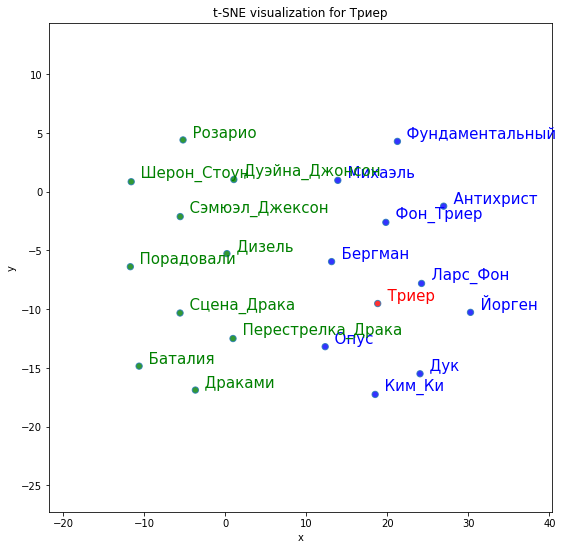

In [381]:
tsnescatterplot(w2v_model, word, [i[0] for i in w2v_model.wv.most_similar(negative=[word])])

# Machine learning

We load the trained Word2Vec model and generate word embeddings for a set of documents in a corpus.

Since doc_embedding is a two-dimensional array, where each row represents a word embedding and each column represents a dimension of the embedding space, taking the mean along axis 0 results in a new one-dimensional array where each element represents the mean value of the corresponding column across all the word embeddings in the document.

By taking the mean of the word embeddings, we obtain a single vector representation of the document that summarizes the semantic information of all the words in the document. This is commonly referred to as a "document-level embedding" or "document vector".

 We use them as features

In [225]:
#@title Get the average of the word embeddings of a document to get a document-level embedding
def get_doc_embedding(doc) -> list:
    doc_embeddings = [w2v_model.wv[word] for word in doc.split() if word in w2v_model.wv.vocab]
    if len(doc_embeddings) > 0:
        return np.mean(doc_embeddings, axis=0)

In [226]:
df_clean['text_embedding'] = df_clean['text_lem'].apply(get_doc_embedding)

When using document-level embeddings as features in a machine learning model, it is common to split the embedding vector into separate columns, with each column representing a different dimension of the embedding space.

In [227]:
embedding_cols = [f'embedding_{i+1}' for i in range(dimensionality)]

In [354]:
df_clean = pd.concat([df_clean, pd.DataFrame(df_clean['text_embedding'].to_list(), columns=embedding_cols)], axis='columns')

We split the dataset sample into train, validation and test samples.

In [229]:
from sklearn.model_selection import train_test_split

In [230]:
train, test = train_test_split(df_clean, train_size=0.6, random_state=42, stratify=df['label'])
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['label'])

We use Catboost Classifier as a ML algorithm 

In [231]:
!pip install catboost --quiet

In [232]:
from catboost import CatBoostClassifier

We use document-level embeddings as features for training the Classifier.

In [233]:
input = embedding_cols
output = ['label']

In [234]:
model = CatBoostClassifier(
    verbose=100,
    random_seed=42,
    learning_rate=0.01,
    iterations=1999
)

In [235]:
model.fit(train[input], train[output], eval_set=(val[input], val[output]))

0:	learn: 0.6855511	test: 0.6857816	best: 0.6857816 (0)	total: 105ms	remaining: 3m 28s
100:	learn: 0.3510255	test: 0.3685006	best: 0.3685006 (100)	total: 8.94s	remaining: 2m 48s
200:	learn: 0.2875522	test: 0.3169009	best: 0.3169009 (200)	total: 17.5s	remaining: 2m 36s
300:	learn: 0.2583018	test: 0.2979752	best: 0.2979752 (300)	total: 29s	remaining: 2m 43s
400:	learn: 0.2384618	test: 0.2885714	best: 0.2885714 (400)	total: 36.6s	remaining: 2m 25s
500:	learn: 0.2226570	test: 0.2827455	best: 0.2827455 (500)	total: 46.1s	remaining: 2m 17s
600:	learn: 0.2088099	test: 0.2783774	best: 0.2783774 (600)	total: 55.5s	remaining: 2m 9s
700:	learn: 0.1966960	test: 0.2754161	best: 0.2754161 (700)	total: 1m 3s	remaining: 1m 56s
800:	learn: 0.1851727	test: 0.2728468	best: 0.2728468 (800)	total: 1m 13s	remaining: 1m 49s
900:	learn: 0.1734998	test: 0.2710762	best: 0.2710762 (900)	total: 1m 23s	remaining: 1m 42s
1000:	learn: 0.1621666	test: 0.2694977	best: 0.2694738 (992)	total: 1m 31s	remaining: 1m 31s
11

In [236]:
test['score'] = model.predict_proba(test[input])[:, 1]

In [237]:
test[['review_id', 'label', 'score']]

,review_id,label,score
3987,436269-29,0,0.243534
10616,252107-39,1,0.651606
941,568413-7,1,0.993207
8669,47249-6,1,0.961594
9889,2517-4,1,0.908746
...,...,...,...
6278,270249-11,0,0.372856
7014,321845-33,1,0.983701
889,652692-68,1,0.998015
9418,469670-0,1,0.790856


Log loss, also known as cross-entropy loss, is a loss function used in classification tasks to measure the difference between predicted probabilities and true labels. It is a commonly used loss function in machine learning algorithms such as logistic regression and neural networks.

The log loss formula is:

\begin{equation}
-\log P(y|x),
\end{equation}

where $P(y|x)$ is the predicted probability of class $y$ given input $x$. Log loss penalizes incorrect predictions more heavily than correct predictions.

In [238]:
from sklearn.metrics import log_loss

In [239]:
def print_metrics():
  print(log_loss(test['label'], test['score']))

In [240]:
print_metrics()

0.2541058038540291


# Classification metrics

Let's first consider the threshold 0.5.

In [241]:
test['pred'] = (test['score'] > 0.5) * 1

In [242]:
test[['review_id', 'label', 'score', 'pred']]

,review_id,label,score,pred
3987,436269-29,0,0.243534,0
10616,252107-39,1,0.651606,1
941,568413-7,1,0.993207,1
8669,47249-6,1,0.961594,1
9889,2517-4,1,0.908746,1
...,...,...,...,...
6278,270249-11,0,0.372856,0
7014,321845-33,1,0.983701,1
889,652692-68,1,0.998015,1
9418,469670-0,1,0.790856,1


We check the classification report with the threshold 0.5.

In [243]:
from sklearn.metrics import classification_report

In [244]:
print(classification_report(test['label'], test['pred']))

              precision    recall  f1-score   support

           0       0.76      0.56      0.64       403
           1       0.90      0.96      0.93      1737

    accuracy                           0.88      2140
   macro avg       0.83      0.76      0.79      2140
weighted avg       0.88      0.88      0.88      2140



In [245]:
thrs = [0] + list(test['score'].unique())

In [246]:
from sklearn.metrics import f1_score

Now we find the threshold for the best f1-metric

In [247]:
#@title Add progress bar
from tqdm.notebook import tqdm

In [248]:
result = []
for thr in tqdm(thrs):
  test['pred_new'] = (test['score'] > thr) * 1
  result.append((thr, f1_score(test['label'], test['pred_new'])))

  0%|          | 0/2141 [00:00<?, ?it/s]

In [249]:
#Find the best threshold
best_thr, best_f1 = max(result, key=lambda pair: pair[1])
best_thr, best_f1

(0.6351298631756253, 0.9376430205949656)

The best threshold is 0.63.

In [258]:
test['pred_new'] = (test['score'] > best_thr) * 1

Now we check the classification report with the best threshold.

In [260]:
print(classification_report(test['label'], test['pred_new']))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       403
           1       0.93      0.94      0.94      1737

    accuracy                           0.90      2140
   macro avg       0.84      0.82      0.83      2140
weighted avg       0.90      0.90      0.90      2140



# ROC curve

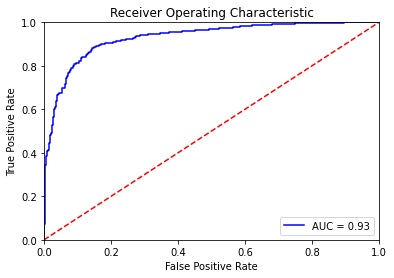

In [251]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(test['label'], test['score'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

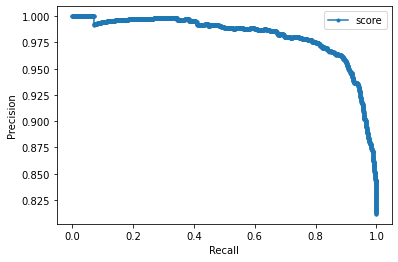

In [252]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

precision1, recall1, _ = precision_recall_curve(test['label'], test['score'])

# plot the precision-recall curves
pyplot.plot(recall1, precision1, marker='.', label='score')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Play

We test the prediction capabilities of the model with 3 reviews generated by me:
* one positive
* one neutral
* one negative

And also 2 reviews on Cheburashka (2023) from Kinoafisha: one positive and one negative

In [ ]:
data = {'reviews': [
    
    'Кино супер, мне зашло.',

    'Фильм отстой, совсем не понравиося, клюква.',

    'Фильм вызвал нейтральные чувства. Не могу понять, понравился или нет.',

    '''Я хочу сказать вам огоромное «СПАСИБО» за такой фильм!
Смотрел трейлер, думал очередной фильмишка, но ради Чебурашки схожу.
Знаете, я ошибался и очень рад этому.
В этом фильме 85% сюжета с чебурашкой, это замечательно, что не стали строить фильм на людях, а включили почти в весь сюжет милого персонажа
Благодаря фильму, я увидел новую интерпретацию советского мультика. У вас получилось!
Чебурашка стал для меня на всю жизнь чем-то добрым, не винным, замечательным персонажем. 
В некоторых моментах фильма хочется, чтобы он был в нашей реальности.
По началу смеешься над чебурашкой, потом плачешь из-за сплетения 2 историй, прошлой и настоящей.
Гена, в прошлом потерял жену и отдал свою дочь, и в настоящем он чтобы защитить свою взрослую дочь отдает ЧЕБУРАШКУ шапокляке.
В тот момент весь зрительный зал плакал.
По итогу, чебурашка разочаровывается в людях. Он сказал, что все люди плахие. Когда он это говорит, хочется еще раз плакать.
Потом еще раз все плачут из-за того, что в развязки у них все наладилось, они все вместе и в финале Гена на гармошке играет легендарную песню.
А я играю, на гармошке...
ОГРОМНОЕ ВАМ СПАСИБО ЗА ФИЛЬМ!
Сходите, не пожалете!''',

  '''Финальная рецензия. :)
Такой откровенной ХАЛТУРЫ я в кинотеатре еще не смотрел!
Анимация низкокачественная, не «врисованна» в картину, а «приклеена» к ней! Местами персонаж двигается отдельно от фона. 
Даже волосяной покров на чебурашке упорно не хочет шевелиться.
Сюжет к Чебурашке притянут «за уши».
Авторские посылы увиденные мной приведены ниже.
Авторский посыл 1: Главное — семья, но семья этого не оценит! «Безысходность»?
Авторский посыл 2: Малый бизнес — это хорошо, но заниматься им нет смысла т. к. вас 100% задушит крупный бизнес с низкопробным продуктом!
«Безысходность» или отсылка к крупным партнерам в титрах?
Авторский посыл 3: забудьте о деньгах, живите для семьи и не «высовывайтесь», иначе Вас втопчут в грязь более «эффективные бизнесмены/менеджеры».
Намек подрастающему поколению о безысходности?! Добавлю, в кино из «недружественных» стран обычно «пресмыкание» показано с точки зрения высмеивания персонажей окружающих «успешного»/богатого/властного человека ("шакалов»), а здесь это преподнесено как норма общения с «успешными людьми»!
И еще раз про «Безысходность» — это фраза Чебурашки из фильма!!!
Если кратко о фильме, то это аналог сериала «Кухня», только с Гармашем, Добронравовым , Яковлевой и Чебурашкой (непонятно зачем он здесь т. к. не отпускает ощущение, что его «вписали» в уже готовый сценарий фильма), местами вызывает улыбку, местами давит на слезу, но в целом ЭТО ВТОРОСОРТНЫЙ ПРОДУКТ ДЛЯ ТВ, но никак НЕ ДЛЯ КИНОТЕАТРА.
Причины высоких сборов: Безысходность!!! Агрессивные реклама и пиар + в кинотеатр с ребенком сейчас больше не на что пойти…'''
    ]}

In [363]:
#@title Clean and process play reviews
df_play = pd.DataFrame.from_dict(data)
df_play['text_cleaned'] = df_play['reviews'].map(brief_clean)
df_play['text_lem'] = df_play['text_cleaned'].apply(lemmatize_without_stops)
df_play['text_embedding'] =  df_play['text_lem'].apply(get_doc_embedding)
df_play = pd.concat([df_play, pd.DataFrame(df_play['text_embedding'].to_list(), columns=embedding_cols)], axis='columns')
df_play['score'] = model.predict_proba(df_play[input])[:, 1]
df_play['pred'] = (df_play['score'] > best_thr) * 1
df_play[['text_cleaned', 'score', 'pred']]

,text_cleaned,score,pred
0,кино супер мне зашло,0.839671,1
1,фильм отстой совсем не понравиося клюква,0.061798,0
2,фильм вызвал нейтральные чувства не могу понят...,0.447379,0
3,я хочу сказать вам огоромное спасибо за такой ...,0.990096,1
4,финальная рецензия такой откровенной халтуры я...,0.139745,0
